### Use Spark NLP for Text Classification

* Spark NLP is an open-source text processing library for advanced natural language processing for the Python, Java and Scala programming languages.

* The library is built on top of Apache Spark and its Spark ML library.

* It is currently the most widely used NLP library in the enterprise.

* In this tutorial, we will learn how to use Spark NLP for text preprocessing and build machine learning models to classify text into different categories.

In [ ]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2024-07-03 11:57:55--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 3.86.22.73
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|3.86.22.73|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2024-07-03 11:57:56--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191 (1.2K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.16K  --.-KB/s    in 0s      

Installing PySpark 3.2.3 and Spark NLP 5.4.0
2024-07-03 11:57:56 (87.9 MB/s) - writ

In [ ]:
# Import modules
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.sql.functions import expr
from pyspark.sql import functions as fun
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
import sparknlp
from sparknlp import DocumentAssembler, Finisher
from sparknlp.annotator import *
from pyspark.ml.classification import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *

In [ ]:
# Mount my google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## BBC News Summary Dataset

Sources: https://www.kaggle.com/datasets/pariza/bbc-news-summary; http://mlg.ucd.ie/datasets/bbc.html

\
The dataset consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005. There are five class Labels: business, entertainment, politics, sport, and tech.

\
Dataset structure:

\
* News Articles
  * business (txt files, e.g., 001.txt)
  * entertainment (txt files)
  * politics (txt files)
  * sport (txt files)
  * tech (txt files)

\
* Summaries
  * business (txt files, e.g., 001.txt)
  * entertainment (txt files)
  * politics (txt files)
  * sport (txt files)
  * tech (txt files)

In [ ]:
# Start the Spark NLP session
spark = sparknlp.start()

In [ ]:
# In Spark NLP, wholeTextFile() will return an error when it finds a nested folder.
# Therefore, we need to create a file path list by traversing all nested folders
# and pass all file names with comma separator in order to create a single RDD.
root = '/content/drive/My Drive/BBC News Summary/Summaries'
lst_filenames = [os.path.join(path, name) for path, subdirs, files
                 in os.walk(root) for name in files]
print(len(lst_filenames))
lst_filenames[:5]

510


['/content/drive/My Drive/BBC News Summary/Summaries1/tech/005.txt',
 '/content/drive/My Drive/BBC News Summary/Summaries1/tech/004.txt',
 '/content/drive/My Drive/BBC News Summary/Summaries1/tech/002.txt',
 '/content/drive/My Drive/BBC News Summary/Summaries1/tech/001.txt',
 '/content/drive/My Drive/BBC News Summary/Summaries1/tech/006.txt']

In [ ]:
# Use Spark NLP to import all txt files in the list (filenames seperated by comma)
texts = spark.sparkContext.wholeTextFiles(','.join(lst_filenames))

In [ ]:
# Create a schema for the imported files
schema = StructType([
  StructField('filename', StringType()),
  StructField('text', StringType())
])

In [ ]:
# Create a Spark NLP dataframe
texts = spark.createDataFrame(texts, schema = schema)
texts.show()

+--------------------+--------------------+
|            filename|                text|
+--------------------+--------------------+
|file:/content/dri...|"We are hoping to...|
|file:/content/dri...|He said one lapto...|
|file:/content/dri...|Laws on net cafe ...|
|file:/content/dri...|The other common ...|
|file:/content/dri...|The Agricultural ...|
|file:/content/dri...|Microsoft is inve...|
|file:/content/dri...|Microsoft is inve...|
|file:/content/dri...|People chosen to ...|
|file:/content/dri...|More people are b...|
|file:/content/dri...|A US woman is sui...|
|file:/content/dri...|A rapid alerting ...|
|file:/content/dri...|The European Parl...|
|file:/content/dri...|Microsoft is work...|
|file:/content/dri...|Web tracking comp...|
|file:/content/dri...|The Legal Affairs...|
|file:/content/dri...|Mr Hogan said 90%...|
|file:/content/dri...|IBM said it had t...|
|file:/content/dri...|Sony, IBM and Tos...|
|file:/content/dri...|Every month the p...|
|file:/content/dri...|"If you ha

In [ ]:
# We can convert the Spark NLP dataframe to Pandas dataframe
texts.limit(5).toPandas()

,filename,text
0,file:/content/drive/My Drive/BBC News Summary/...,"""We are hoping to understand the creative indu..."
1,file:/content/drive/My Drive/BBC News Summary/...,"He said one laptop per child could be "" very i..."
2,file:/content/drive/My Drive/BBC News Summary/...,Laws on net cafe opening hours and who can use...
3,file:/content/drive/My Drive/BBC News Summary/...,The other common type of ink in elections is i...
4,file:/content/drive/My Drive/BBC News Summary/...,The Agricultural Information Project for Farme...


In [ ]:
# Create a new column that stores the article topics for the text summarries
# Note: getItem will get the item by its index, which starts from 0
texts = texts.withColumn(
  'topic',
  fun.split('filename', '/').getItem(6)
  )

In [ ]:
 # Take a look at the newly created label column
texts.limit(5).toPandas()

,filename,text,topic
0,file:/content/drive/My Drive/BBC News Summary/...,"""We are hoping to understand the creative indu...",tech
1,file:/content/drive/My Drive/BBC News Summary/...,"He said one laptop per child could be "" very i...",tech
2,file:/content/drive/My Drive/BBC News Summary/...,Laws on net cafe opening hours and who can use...,tech
3,file:/content/drive/My Drive/BBC News Summary/...,The other common type of ink in elections is i...,tech
4,file:/content/drive/My Drive/BBC News Summary/...,The Agricultural Information Project for Farme...,tech


([<matplotlib.axis.XTick at 0x7af444b655a0>,
 [Text(0, 0, 'politics'), Text(1, 0, 'tech'), Text(2, 0, 'sport')])

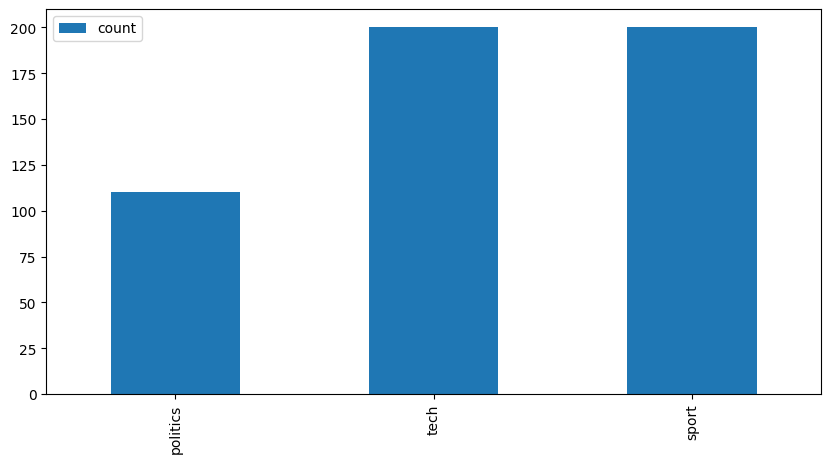

In [ ]:
# Take a look at the number of documents pertaining to each label
label_counts = texts.groupBy('topic').count().toPandas()
label_counts.plot(kind = 'bar', figsize = (10, 5))
plt.xticks(
  ticks = range(len(label_counts)),
  labels = label_counts['topic']
 )

([<matplotlib.axis.XTick at 0x7af437cf16f0>,
 [Text(0, 0, 'politics'), Text(1, 0, 'tech'), Text(2, 0, 'sport')])

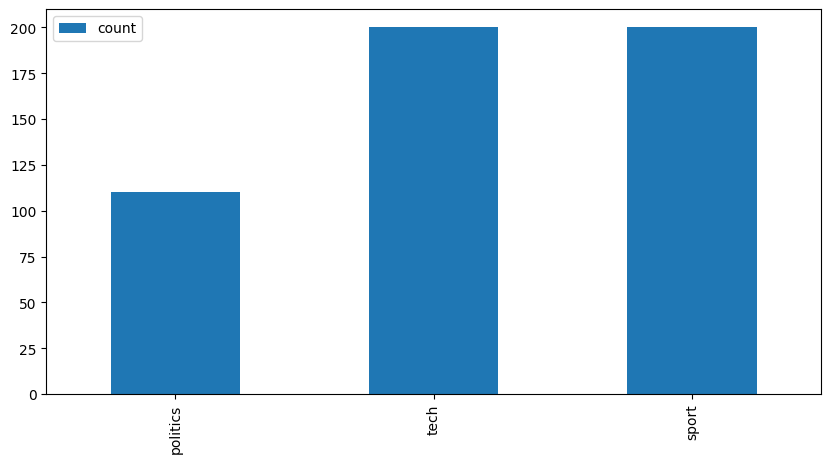

In [ ]:
label_counts.plot(kind = 'bar', figsize = (10, 5))
plt.xticks(
  ticks = range(len(label_counts)),
  labels = label_counts['topic']
 )

In [ ]:
# Take a look at the schema of the Spark NLP dataframe
texts.printSchema()

root
 |-- filename: string (nullable = true)
 |-- text: string (nullable = true)
 |-- topic: string (nullable = true)



In [ ]:
# Randomly split the Spark NLP dataframe into train and test sets
train, test = texts.randomSplit([0.8, 0.2], seed = 123)

In [ ]:
# Define the assembler
assembler = DocumentAssembler()\
  .setInputCol('text')\
  .setOutputCol('document')
docs = assembler.transform(texts)
docs.limit(5).toPandas()

,filename,text,topic,document
0,file:/content/drive/My Drive/BBC News Summary/...,"""We are hoping to understand the creative indu...",tech,"[(document, 0, 2096, ""We are hoping to underst..."
1,file:/content/drive/My Drive/BBC News Summary/...,"He said one laptop per child could be "" very i...",tech,"[(document, 0, 1141, He said one laptop per ch..."
2,file:/content/drive/My Drive/BBC News Summary/...,Laws on net cafe opening hours and who can use...,tech,"[(document, 0, 883, Laws on net cafe opening h..."
3,file:/content/drive/My Drive/BBC News Summary/...,The other common type of ink in elections is i...,tech,"[(document, 0, 1690, The other common type of ..."
4,file:/content/drive/My Drive/BBC News Summary/...,The Agricultural Information Project for Farme...,tech,"[(document, 0, 1828, The Agricultural Informat..."


In [ ]:
# Define the sentence detector
sentence = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentences")
docs = sentence.transform(docs)
docs.limit(5).toPandas()

,filename,text,topic,document,sentences
0,file:/content/drive/My Drive/BBC News Summary/...,"""We are hoping to understand the creative indu...",tech,"[(document, 0, 2096, ""We are hoping to underst...","[(document, 0, 2096, ""We are hoping to underst..."
1,file:/content/drive/My Drive/BBC News Summary/...,"He said one laptop per child could be "" very i...",tech,"[(document, 0, 1141, He said one laptop per ch...","[(document, 0, 149, He said one laptop per chi..."
2,file:/content/drive/My Drive/BBC News Summary/...,Laws on net cafe opening hours and who can use...,tech,"[(document, 0, 883, Laws on net cafe opening h...","[(document, 0, 883, Laws on net cafe opening h..."
3,file:/content/drive/My Drive/BBC News Summary/...,The other common type of ink in elections is i...,tech,"[(document, 0, 1690, The other common type of ...","[(document, 0, 1690, The other common type of ..."
4,file:/content/drive/My Drive/BBC News Summary/...,The Agricultural Information Project for Farme...,tech,"[(document, 0, 1828, The Agricultural Informat...","[(document, 0, 614, The Agricultural Informati..."


In [ ]:
# Define the word tokenizer
tokenizer = Tokenizer()\
  .setInputCols(['sentences'])\
  .setOutputCol('tokens')

In [ ]:
# Define the lemmetizer
lemmatizer = LemmatizerModel.pretrained()\
  .setInputCols(['tokens'])\
  .setOutputCol('lemma') # show Output

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [ ]:
# Define the normalizer
normalizer = Normalizer()\
  .setInputCols(['lemma'])\
  .setOutputCol('normalized')\
  .setLowercase(True)

In [ ]:
# Define the finisher
finisher = Finisher()\
  .setInputCols(['normalized'])\
  .setOutputCols(['normalized'])\
  .setOutputAsArray(True)

In [ ]:
# Define the stop words
stopwords = set(StopWordsRemover.loadDefaultStopWords('english'))
print(stopwords)

# Define the stopword remover
sw_remover = StopWordsRemover()\
  .setInputCol('normalized')\
  .setOutputCol('filtered')\
  .setStopWords(list(stopwords))

{'me', 'this', 'what', 'from', 'off', 'own', 'before', 't', 'to', "you'd", 'he', 'where', "how's", "mustn't", "you're", 'its', 'few', 'more', 'or', 'doing', 'could', 'very', 'through', 'too', 'while', 'if', "here's", "what's", 'yourself', 'ours', 'herself', 'here', 'should', 'and', 'been', 'each', 'after', 'be', 'i', 'himself', 'with', 'below', 'nor', "didn't", 'in', 'only', "i've", 'these', "why's", 'does', "hasn't", 'her', 'same', 'all', "we're", "that's", "when's", 'a', 'as', 'between', 'myself', 'their', "he'd", 'hers', "they've", 'has', 'she', 'itself', 'there', 'for', 'until', 'yours', 'which', 'our', 'during', 'those', 'further', 'no', 'at', "i'm", 'once', "they'd", "they're", 'such', 'is', "where's", 'than', 'about', "i'd", "i'll", "can't", 'that', 'not', "won't", 'now', "wouldn't", 'them', 'up', "we've", 'we', 'his', 'most', 'cannot', 'ought', 'my', 'you', "we'd", 'don', 'they', "haven't", "don't", "aren't", "shouldn't", 'whom', 'when', "wasn't", "she's", 'yourselves', 'so', "

In [ ]:
# Define count vectorizer
count_vectorizer = CountVectorizer(
  inputCol = 'filtered',
  outputCol = 'tf', minDF = 10
  )

In [ ]:
# Define TF-IDF
tfidf = IDF(
  inputCol = 'tf',
  outputCol = 'tfidf',
  minDocFreq = 10
  )

In [ ]:
# Define the pipeline
text_processing_pipeline = Pipeline(
  stages = [
    assembler,
    sentence,
    tokenizer,
    lemmatizer,
    normalizer,
    finisher,
    sw_remover,
    count_vectorizer,
    tfidf
   ])

In [ ]:
# Define a function to convert labels to indices and use it to fit the data
label_indexer = StringIndexer(
  inputCol = 'topic',
  outputCol = 'label').fit(texts)

In [ ]:
# Take a look at the indexed labels
label_indexer.labels

['sport', 'tech', 'politics']

In [ ]:
# Define a function to convert predicted indices to labels
prediction_deindexer = IndexToString(
  inputCol = 'prediction',
  outputCol = 'pred_label',
  labels = label_indexer.labels)

In [ ]:
# Define a model
naive_bayes = NaiveBayes(featuresCol = 'tfidf')

In [ ]:
# Define the overall pipeline
pipeline = Pipeline(
  stages = [
    text_processing_pipeline,
    label_indexer,
    naive_bayes,
    prediction_deindexer
  ])

In [ ]:
# Train the model
model = pipeline.fit(train)

In [ ]:
# Make predictions on the train and test sets
train_predicted = model.transform(train)
test_predicted = model.transform(test)

In [ ]:
# Innitiate the F1 score
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')

In [ ]:
# Report the F1 score on the train set
print('f1 on train set', evaluator.evaluate(train_predicted))

f1 on train set 0.9880074299785647


In [ ]:
# Report the F1 score on the test set
print('f1 on test set', evaluator.evaluate(test_predicted))

f1 on test set 0.9788808701693263


In [ ]:
# Define a function to try out different ML models
def fit_model(model):

  # Define the type of model
  model_type = model(featuresCol = 'tfidf')

  # Construct the overall pipeline
  pipeline = Pipeline(
  stages = [
    text_processing_pipeline,
    label_indexer,
    model_type,
    prediction_deindexer
  ])

  # Train the model
  model = pipeline.fit(train)

  # Make predictions on the train and test sets
  train_predicted = model.transform(train)
  test_predicted = model.transform(test)

  # Innitiate the F1 score
  evaluator = MulticlassClassificationEvaluator(metricName = 'f1')

  # Report the F1 score on the train set
  print(f'{str(model)}: f1 on train set', evaluator.evaluate(train_predicted))

  # Report the F1 score on the test set
  print(f'{str(model)}: f1 on test set', evaluator.evaluate(test_predicted))

In [ ]:
# Fit a logistic regression
fit_model(LogisticRegression)

PipelineModel_80db8f4bf865: f1 on train set 1.0
PipelineModel_80db8f4bf865: f1 on test set 0.9129377161635226


In [ ]:
# Fit a random forest classifier
fit_model(RandomForestClassifier) # show accuracy score

PipelineModel_b43fc065d8a8: f1 on train set 0.8770458872116675
PipelineModel_b43fc065d8a8: f1 on test set 0.8498437954083116
